# Solvent-accessible surfaces vs solvent-excluded surfaces

The concept of a solvent-excluded surface is intuitive, but it's difficult to calculate.

A starting point is the hard-sphere approximation of a molecule. In this approximation, each atom is a perfect sphere with radius defined by the van Der Waals radius. 

The solvent-accessible surface (SAS) is similar to the hard-sphere surface, but removes any surfaces on the internal parts of the molecule, as well as tiny crevices on the external parts. Imagine a probe sphere rolling around the surface of a molecule. The SAS is the shape defined by the probe's path. It's reasonably easy to calculate SAS-area (SASA) using the [Shrake-Rupley](https://en.wikipedia.org/wiki/Accessible_surface_area) algorithm.

A related concept is the solvent-excluded surface (SES), which is where life gets difficult. The SES is the hard sphere approximation when there is room for a probe sphere to contact an atom surface. Inbetween two atoms, however, the SES becomes the surface of the probe sphere, which is known as a re-entrant surface. The canonical analytical approach to calculating it is by Connolly's approach ([doi](https://doi.org/10.1107/S0021889883010985)), which uses hourglass-shaped patches to fill the SES between atoms.

### Here's an outline of the three surfaces from the Chimera docs:

![bah](https://www.cgl.ucsf.edu/chimerax/docs/user/commands/surface-diagram.png)

# Molecular volume

Arguably, the best overlap between two ligands is the one that maximises their overlapping volume. The union of atomic volumes can be calculated analytically with geometry, and a famous paper by Andrew Grant ([doi](https://doi.org/10.1002/(SICI)1096-987X(19961115)17:14<1653::AID-JCC7>3.0.CO;2-K)) showed how to do it with a Gaussian approximation of the atoms. This is nice in that the volume overlap has a gradient, and the 'fuzziness' kind of represents an electron cloud. 

But that's the union of atomic volumes. The volume of a molecule also includes the excluded spaces between atoms, and a protein shouldn't care whether the actual atoms overlap or not. 

Instead, this notebook shows how to calculate SES's and their volumes. The SES is approximated with a mesh, and there is a handy and fast algorithm for calculating the volume of a watertight mesh ([doi](https://doi.org/10.1109/ICIP.2001.958278)).

To make life simple, we start in the 2d case.


In [52]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from skimage.measure import find_contours

# SETUP
Generate two 'atoms' - really just 2D point clouds sampled from the surfaces of two circles. We will also copy those points and expand their distance from the atom centres by one 'probe radius' to sample points from the SAS.

Note: for the rest of the notebook, the atom-surface points will be **BLUE**, and the SAS/SES points will be **ORANGE**.

In [53]:
def plot_points(p, ep):
    """Plots the surface points (p) and extended surface points (ep)"""
    fig, ax = plt.subplots()
    fig.set_figwidth(12)
    fig.set_figheight(12)
    ax.scatter(*p.T, s=80)
    ax.scatter(*ep.T, s=80)



    ax.set_xlim(0,len(xx))
    ax.set_ylim(0,len(xx))
    ax.set_aspect('equal')
    return fig, ax 

(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

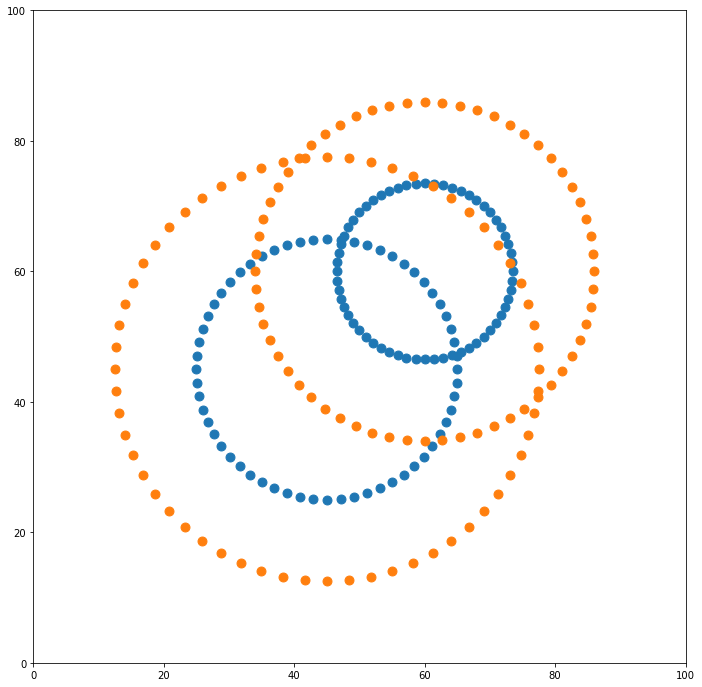

In [64]:
def circle_points(r, n):
    """Sample points spread out around a unit circle"""
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 2*np.pi, n, endpoint=False)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

#num points:
n = 60
#get the points:
pts = circle_points([1], [n])[0]



#create an underlying grid
xx = np.linspace(0,100, 100)

#set the coordinates of two 'atoms', which lie somewhere on the grid.
positions = np.array([[xx.max()*.45,xx.max()*.45], [xx.max()*.60,xx.max()*.60]])

#set some radii for the atoms. I just chose some nice numbers
radii = np.array([ xx.max()*0.20, xx.max()*0.135])

#the radius of the probe circle.
PROBERAD = xx.max()*.125

###
##Now construct the atoms - this just uses numpy to repeat the `pts` while 
##multiplying them by the radii or the radii+PROBERAD to get surface points
##and SAS points
###

##calculate the radius associated with each point, aka distance from nearest atom.
all_radii = np.repeat(radii, n)

##surface points:
#repeat the points and multiply by radii
t = np.tile(pts,(len(positions),1)) *np.repeat(radii, n)[:,None]
#now transform by positions
p = t+np.repeat(positions, n,axis=0)

#repeat the points and multiply by radii
ep = np.tile(pts,(len(positions),1)) *np.repeat(radii+PROBERAD, n)[:,None]
#now transform by positions
ep = ep+np.repeat(positions, n,axis=0)


plot_points(p, ep)

# Remove points that lie inside another atom.

These are the easy ones. Simply calculate the minimum distance between a blue point and the atom coordinates. If it's less than the radius of that atom, get rid of it.

Note: you can see some blue points that are actually within 

(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

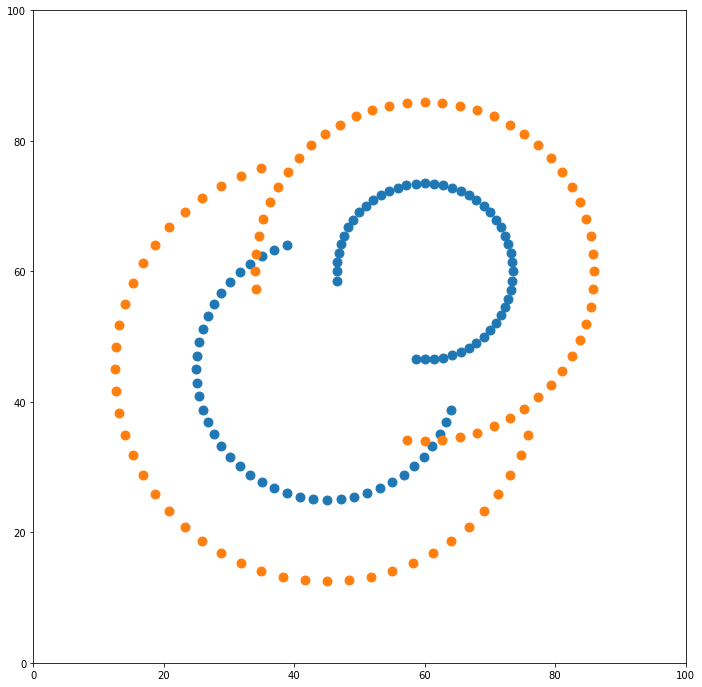

In [65]:
#remove any blue point that is inside another atom (and also their attendant orange points.)
dmat = cdist(p, positions)
inside = dmat.min(1)<(all_radii-0.000001)

#apply the mask:
p = p[~inside]
ep = ep[~inside]

#also apply it to the radii associated with the bluez points:
all_radii = all_radii[~inside]

plot_points(p, ep)

In [66]:
# #remove any orange point that is inside another atom (but not their attendant blue points.)
# dmat = cdist(ep, positions)
# inside = dmat.min(1)<((PROBERAD+all_radii)-0.000001)

# #apply the mask:
# #p = p[~inside]
# ep = ep[~inside]

# #also apply it to the radii associated with the bluez points:
# all_radii = all_radii[~inside]

# plot_points(p, ep)

# Remove any SAS points (orange) where a probe sphere couldn't fit

The orange points represent the centre of a probe sphere. So if a point is within one probe radius of a blue point, get rid of it. 

(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

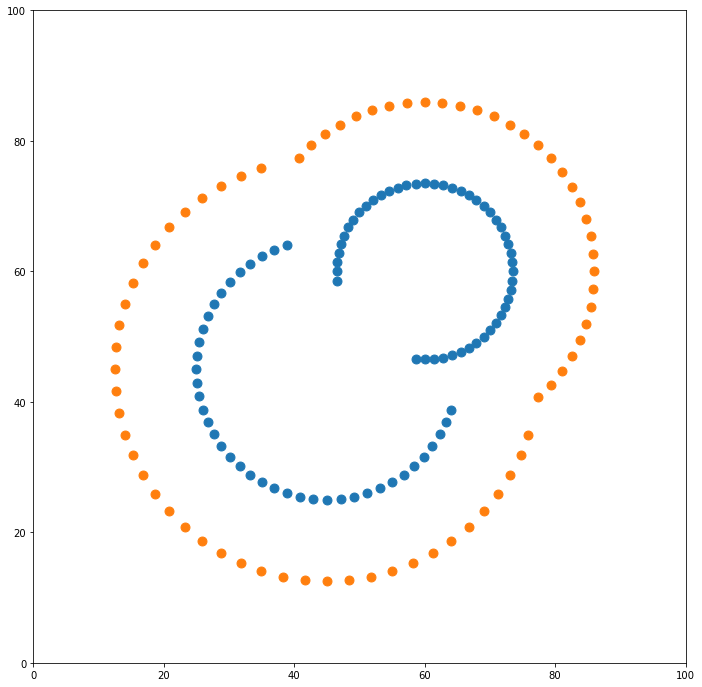

In [67]:
#now remove any orange point that is too close to a blue point. 

dmat = cdist(ep, p)
too_close = dmat.min(1)<(PROBERAD-0.000001)

ep = ep[~too_close]
dmat = dmat[~too_close]

plot_points(p, ep)

# Now translate the problematic blue points to be 1 probe radius from their nearest probe

In [70]:
blue_idx = dmat.min(0)>(PROBERAD+0.0001)
orange_idx = dmat[:,blue_idx].argmin(0)

vec = ep[orange_idx] - p[blue_idx]

scaling = 1 - (PROBERAD / np.linalg.norm(vec,axis=1))
p[blue_idx] +=(scaling[:,None]*vec)

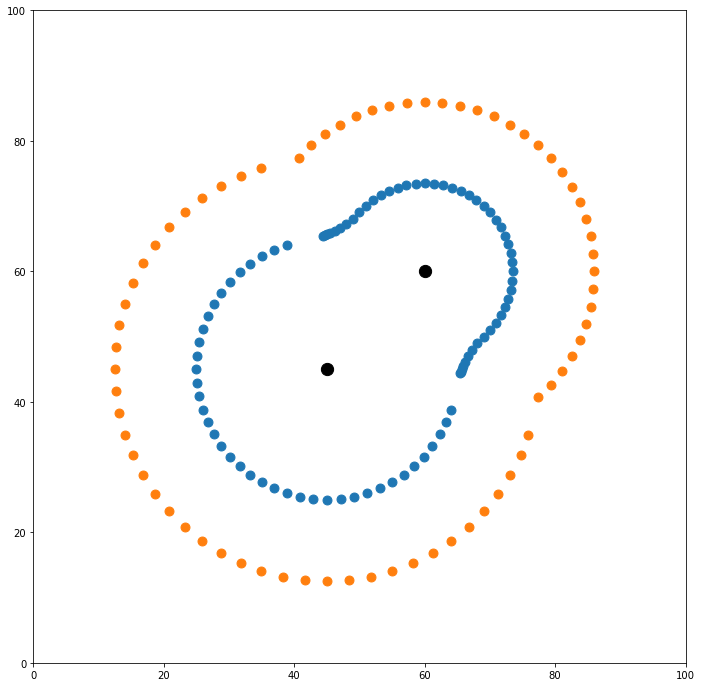

In [71]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(12)

ax.scatter(*p.T, s=80)
ax.scatter(*ep.T, s=80)
ax.scatter(*positions.T, s=150, c='k')


ax.set_xlim(0,len(xx))
ax.set_ylim(0,len(xx))
ax.set_aspect('equal')

# Interpolate onto a grid:
We already know that all the blue points are on the atom surface, so they have a surface distance of zero. Likewise we know that, after shifting those blue points, all the orange points are one probe radius away from the solvent-excluded surface.

In order to turn this into a volume mesh, we need a signed distance field (SDF), which is a regular grid (a 3D array) where each value is the distance from the grid coordinate to the solvent-excluded surface. `scipy.interpolate.griddata` can do this if given the grid coordinates and the values of the distances from some points within the grid.

To help it along, we add a point at each atom position with the value of `-radius`, which is the signed distance from the solvent-excluded surface.



In [72]:
blue_distances = np.zeros(p.shape[0])
orange_distances = np.ones(ep.shape[0])*PROBERAD

pts3 = np.vstack([p,ep, positions])
z3 = np.hstack([blue_distances,orange_distances, -radii])



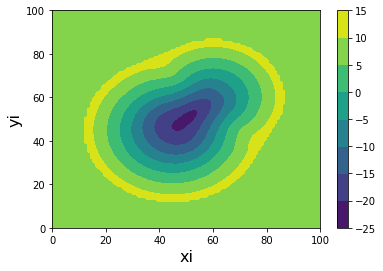

In [73]:
from scipy.interpolate import griddata

a,b = np.meshgrid(xx, xx)
grid = np.stack((a.ravel(), b.ravel()),axis=1)


# interpolate
zi = griddata((pts3[:,0], pts3[:,1]),z3, (a,b),method='cubic', fill_value = 10)

# # mask out the field
# zi[mask] = np.nan

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.contourf(a,b,zi,)

plt.xlabel('xi',fontsize=16)
plt.ylabel('yi',fontsize=16)
plt.colorbar()




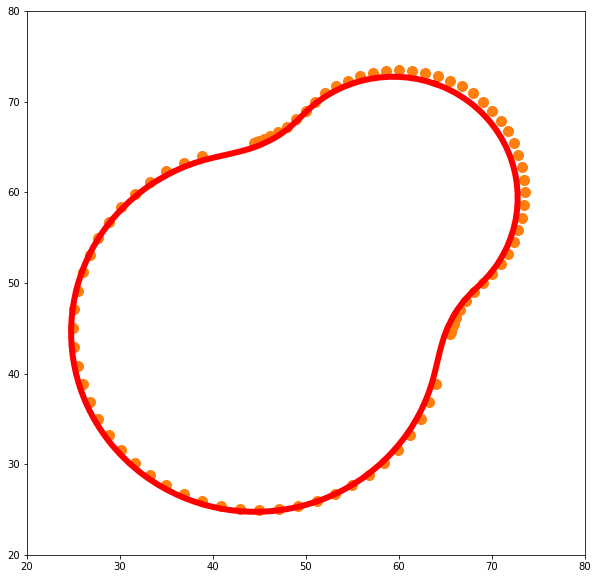

In [74]:
fig,ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
contours = find_contours(zi, 0)
for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=6, c='red')

# ax.set_xlim(0,xx.max())
# ax.set_ylim(0,xx.max())
ax.set_xlim(20,80)
ax.set_ylim(20,80)
ax.scatter(*p.T,s=100,c='C1')


# Try a molecule!

In [75]:
def golden_spiral(num_pts, radius=1):

    indices = np.arange(0, num_pts, dtype=float) + 0.5
    phi = np.arccos(1 - 2*indices/num_pts)
    theta = np.pi * (1 + 5**0.5) * indices
    x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi);
    points = np.vstack([x,y,z]).T
    return points*radius



n = 60

pts = golden_spiral(n)

In [78]:
from mol3d import Mol3D
from rdkit import Chem

mol = Mol3D('CC(C)N1C[C@H](C)[C@H](NC(=O)N2Cc3ccccc3[C@@H]2C)C1')
mol.embed3d(1, hydrogens=True)

positions = mol.get_pos(0)
radii = np.array([Chem.GetPeriodicTable().GetRvdw(a.GetAtomicNum()) for a in mol.mol.GetAtoms()])+0.1


In [79]:
PROBERAD = 1.4

In [80]:
#add points:

##calculate the radius associated with each point.
all_radii = np.repeat(radii, n)


##surface points:
#repeat the points and multiply by radii
t = np.tile(pts,(len(positions),1)) *np.repeat(radii, n)[:,None]
#normals are easy because the points were already from the origin:
normals = np.tile(pts,(len(positions),1))

#now transform by positions
p = t+np.repeat(positions, n,axis=0)

#repeat the points and multiply by radii
et = np.tile(pts,(len(positions),1)) *np.repeat(radii+PROBERAD, n)[:,None]
#now transform by positions
ep = et+np.repeat(positions, n,axis=0)

In [81]:
#first remove any blue point that is inside another atom (and also their attendant orange points.)

dmat = cdist(p, positions)
inside = dmat.min(1)<(all_radii-0.000001)

#

p = p[~inside]
ep = ep[~inside]
normals = normals[~inside]

all_radii = all_radii[~inside]


In [82]:
#now remove any orange point that is too close to a blue point. 

dmat = cdist(ep, p)
too_close = dmat.min(1)<(PROBERAD-0.000001)

ep = ep[~too_close]
dmat = dmat[~too_close]


In [83]:
blue_idx = dmat.min(0)>(PROBERAD+0.0001)
orange_idx = dmat[:,blue_idx].argmin(0)
vec = ep[orange_idx] - p[blue_idx]
scaling = 1 - (PROBERAD / np.linalg.norm(vec,axis=1))
p[blue_idx] +=(scaling[:,None]*vec)

In [84]:
pts3 = np.vstack([p,ep, positions])
z3 = np.hstack([np.zeros(p.shape[0]),np.ones(ep.shape[0])*PROBERAD, -radii])



In [115]:
buff = max(radii)+0.6

x1, y1, z1 = np.rint((positions.min(0)-buff)*10)/10
x2, y2, z2 = np.rint((positions.max(0)+buff)*10)/10

spacing = 1.5
x = np.arange(x1, x2, spacing)
y = np.arange(y1, y2, spacing)
z = np.arange(z1,z2, spacing)

a,b,c = np.meshgrid(x, y, z)
grid = np.stack((a.ravel(), b.ravel(), c.ravel()), axis=1)

In [116]:
%%time
zi = griddata((pts3[:,0], pts3[:,1], pts3[:,2]), z3, (a,b,c),method='linear', fill_value = PROBERAD)



CPU times: user 309 ms, sys: 16 ms, total: 325 ms
Wall time: 127 ms


In [117]:
import meshplot as mp

In [118]:
from skimage.measure import marching_cubes_lewiner
vert, faces, norm, values= marching_cubes_lewiner(zi, 0,spacing=(spacing,spacing,spacing))

mp.plot(vert, faces)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.1368799…

In [142]:
from jax import vmap, jit
import jax.numpy as jnp

@jit
def signed_vol_of_triangle(p1, p2, p3):
    v321 = p3[0]*p2[1]*p1[2]
    v231 = p2[0]*p3[1]*p1[2]
    v312 = p3[0]*p1[1]*p2[2]
    v132 = p1[0]*p3[1]*p2[2]
    v213 = p2[0]*p1[1]*p3[2]
    v123 = p1[0]*p2[1]*p3[2]
    return (1 / 6)*(-v321 + v231 + v312 - v132 - v213 + v123)


def make_vol(pts):
    return signed_vol_of_triangle(pts[0], pts[1], pts[2])

vmake_vol = vmap(make_vol)

In [143]:
tris = vert[faces]

In [152]:
%%time
vmake_vol(tris).sum()

CPU times: user 7.72 ms, sys: 1.75 ms, total: 9.47 ms
Wall time: 9.62 ms


DeviceArray(338.36255, dtype=float32)

In [154]:
%%time
vmake_vol(tris).sum()

CPU times: user 8.53 ms, sys: 1.78 ms, total: 10.3 ms
Wall time: 9.79 ms


DeviceArray(338.36255, dtype=float32)

In [106]:
import igl 
lv, lf = igl.loop(vert, faces.astype(int))
v = lv.copy()
f = lf.copy()


In [108]:
mp.plot(v, f)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.1483808…

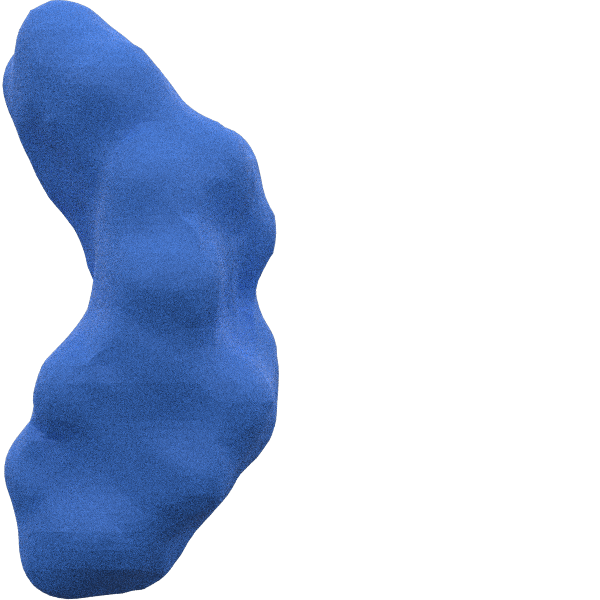

In [134]:
view='front'

n_samples = 50
scene1 = fresnel.Scene()
geom = fresnel.geometry.Mesh(scene1,vertices=v[f].reshape(-1,3),N=1)
geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
scene1.camera = fresnel.camera.fit(scene1,view=view, margin=0)
scene1.lights = fresnel.light.cloudy()
fresnel.pathtrace(scene1, samples=n_samples, h=600, w=600)


In [135]:
f = open('mol.pdb', 'w')
f.write(Chem.MolToPDBBlock(mol.mol))
f.close()

In [136]:
import open3d as o3d
chimera_mesh = o3d.io.read_triangle_mesh('chimera.stl')

In [82]:
chimera_vertices = np.array(chimera_mesh.vertices)
chimera_faces = np.array(chimera_mesh.triangles)

In [88]:
plotly_scatter([chimera_vertices, vert, p*np.array([1,1,1])], [5, 3, 9])
#plotly_scatter([chimera_vertices], [3])

In [80]:
o3d.visualization.draw_geometries([chimera_mesh])

In [ ]:
n_samples = 50
scene1 = fresnel.Scene()
geom = fresnel.geometry.Mesh(scene1,vertices=chimera_vertices[chimera_faces].reshape(-1,3),N=1)
geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
scene1.camera = fresnel.camera.fit(scene1,view=view, margin=0)
scene1.lights = fresnel.light.cloudy()
fresnel.pathtrace(scene1, samples=n_samples, h=600, w=600)


In [84]:
vmake_vol(chimera_vertices[chimera_faces]).sum()

DeviceArray(299.34955, dtype=float32)

In [85]:
vmake_vol((vert)[faces]).sum()

DeviceArray(292.17075, dtype=float32)

In [68]:
from rdkit.Chem.rdFreeSASA import CalcSASA

In [69]:
CalcSASA(mol.mol, list(radii))

523.1744997450389

In [70]:
ComputeMolVolume(mol.mol, 0)

247.58400000000006

In [4]:
import ipyvolume
data =ipyvolume.datasets.hdz2000.fetch()

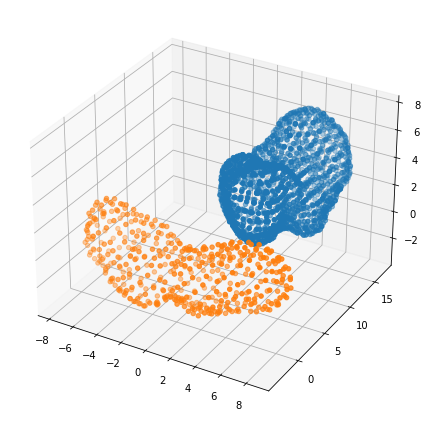

In [75]:
fig = plt.figure(figsize=plt.figaspect(0.5)*1.5)
ax = fig.add_subplot(111, projection="3d")

n=1
ax.scatter(vert[:,0][::n], vert[:,1][::n], vert[:,2][::n])
ax.scatter(p[:,0], p[:,1], p[:,2])

plt.tight_layout()
plt.show()

In [408]:
t = o3d.geometry.TriangleMesh()
t.vertices = o3d.utility.Vector3dVector(v/2)
t.triangles = o3d.utility.Vector3iVector(f)
t.compute_vertex_normals()
t.compute_triangle_normals()
o3d.io.write_triangle_mesh('hi.stl', t)

#o3d.visualization.draw_geometries([t])
#t.get_volume()


True

In [416]:
t2 = o3d.geometry.TriangleMesh()
t2.vertices = o3d.utility.Vector3dVector(chimera_vertices)
t2.triangles = o3d.utility.Vector3iVector(chimera_faces)
t2.compute_vertex_normals()

o3d.visualization.draw_geometries([t2])

In [409]:
t.get_surface_area()

278.6882832159847

In [342]:
t2.get_surface_area()

338.85580607422986

In [326]:
import meshio 

points = np.array(vert)
cells = [("triangle", np.array(faces))]
meshio.write_points_cells('out.obj',points,cells)